In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score, f1_score
import seaborn as sb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Data source: https://zenodo.org/record/5530410#.YYfo3GDML-g (2017 Clickbait challenge)

# Project variables

In [27]:
m_name = "clickbait v5"
p_dir = os.path.join("../cb models", m_name)

In [28]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [29]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [30]:
create_dir(p_dir)
clear_dir(p_dir)

# Prepare dataset

In [31]:
df = pd.read_pickle("../cb models/clickbait.pkl")
df = df.loc[df.title.str.len() <= 100, :]
df.shape

(18104, 2)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18104 entries, 1 to 19537
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      18104 non-null  object 
 1   clickbait  18104 non-null  float64
dtypes: float64(1), object(1)
memory usage: 424.3+ KB


In [33]:
df.head()

,title,clickbait
1,Donald Trump Appoints Pro-Life Advocate as Ass...,1.000000
2,The ‘forgotten’ Trump roast: Relive his brutal...,0.466667
3,"Meet The Happiest Dog In The World, Maru The H...",0.933333
4,Tokyo's subway is shut down amid fears over an...,0.000000
5,World Anti-Doping Agency lifts ban on Madrid l...,0.066667


# Define categories

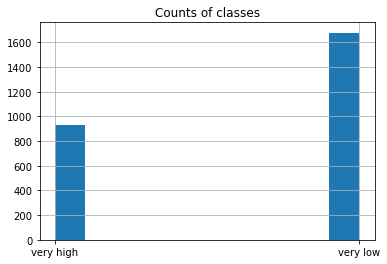

In [34]:
df = df.loc[(df["clickbait"] == 0.0) | (df["clickbait"] >= 0.8), :]
df["qtl"] = "very low"
df.loc[df["clickbait"] != 0.0, "qtl"] = "very high"

df.drop(columns=["clickbait"], inplace=True)

# cat_lbl = ["very low", "low", "high", "very high"]
# df.loc[:, "qtl"] = pd.qcut(df["clickbait"], len(cat_lbl), labels=cat_lbl, precision=6)
# df.sort_values(by=["qtl"]).qtl.hist()

df.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

In [35]:
g = df.groupby(["qtl"]).agg({"title": "count"})
g.rename(columns={"id_video": "cnt"}, inplace=True)
g

,title
qtl,
very high,931
very low,1679


# Split dataset (use only top and bottom quartile data)

In [36]:
# cat_lbl = ["very low", "very high"]
# df = df.loc[df.qtl.isin(cat_lbl)]
# df.qtl = df.qtl.cat.remove_unused_categories()

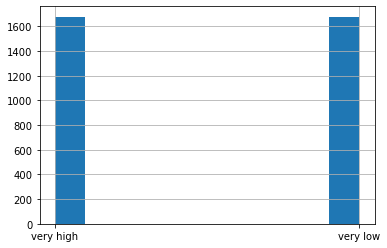

In [37]:
oversampler = RandomOverSampler()
x = df.title
y = df.qtl
x, y = oversampler.fit_resample(x.to_frame(), y)

y.hist()
plt.show()
# The data is about equally distributed between clickbaity and not

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
# x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
# y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_test.shape[0])

2686 672


In [39]:
print(df.loc[df["qtl"] == "very high", "title"].head())

1     Donald Trump Appoints Pro-Life Advocate as Ass...
3     Meet The Happiest Dog In The World, Maru The H...
34    Cheap, widely available drug could stop thousa...
43    Ted Cruz Calls for $14 Billion Seized from ‘El...
49    Here's the cold LinkedIn message that prompted...
Name: title, dtype: object


In [40]:
print(df.loc[df["qtl"] == "very low", "title"].head())

4      Tokyo's subway is shut down amid fears over an...
13     No Zika detected in Florida mosquitoes so far ...
131    Marine dad surprised with magical tea party ph...
154    April the Giraffe, an Internet Star, Gives Bir...
207    Tillerson meets with Putin amid US-Russia disa...
Name: title, dtype: object


# Build the model

In [41]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [42]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [44]:
x_train_pp = preprocess_data(x_train)
x_test_pp = preprocess_data(x_test)

In [45]:
pt_model = "roberta-base"
tok = RobertaTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [46]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True,
                                       return_token_type_ids=True, truncation=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [47]:
transformer_model = TFRobertaModel.from_pretrained(pt_model)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [48]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo TFBaseModelOutputWit 124645632   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 100)     327600      tf_roberta_model_1[0][0]   

In [50]:
x_train_tok = tokenize(x_train_pp, tok)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

batch_size = 64
n_epochs = 20

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_test_tok[:2], y_test_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

2021-11-18 11:06:22.101845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-18 11:06:34.193402: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


42/42 [==============================] - 36s 575ms/step - loss: 0.5600 - accuracy: 0.7025 - val_loss: 0.4398 - val_accuracy: 0.8051

Epoch 00001: val_loss improved from inf to 0.43984, saving model to ../cb models/clickbait v5/clickbait v5
Epoch 2/20
42/42 [==============================] - 22s 520ms/step - loss: 0.3746 - accuracy: 0.8418 - val_loss: 0.4027 - val_accuracy: 0.8140

Epoch 00002: val_loss improved from 0.43984 to 0.40270, saving model to ../cb models/clickbait v5/clickbait v5
Epoch 3/20
42/42 [==============================] - 22s 529ms/step - loss: 0.3390 - accuracy: 0.8582 - val_loss: 0.3458 - val_accuracy: 0.8557

Epoch 00003: val_loss improved from 0.40270 to 0.34576, saving model to ../cb models/clickbait v5/clickbait v5
Epoch 4/20
42/42 [==============================] - 23s 538ms/step - loss: 0.2884 - accuracy: 0.8738 - val_loss: 0.2948 - val_accuracy: 0.8869

Epoch 00004: val_loss improved from 0.34576 to 0.29484, saving model to ../cb models/clickbait v5/clickbai

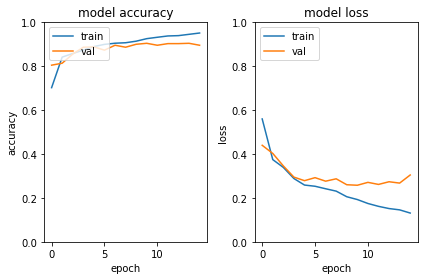

In [51]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [52]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training data (in-sample)

In [53]:
x_train_tok = tokenize(x_train_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)

y_train_prob = model.predict(x_train_tok[:2], steps=y_train_b.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

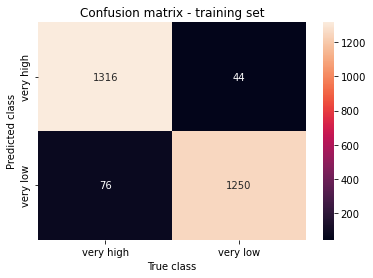

Accuracy: 0.96
Micro precision: 0.96
Micro recall: 0.96
Micro F1-score: 0.96
Macro precision: 0.96
Macro recall: 0.96
Macro F1-score: 0.96
Weighted precision: 0.96
Weighted recall: 0.96
Weighted F1-score: 0.96


In [54]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

## Test data (out-of-sample)

In [55]:
x_test_pp = preprocess_data(x_test)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

In [56]:
print("F1 score: {:0.2f}".format(f1_score(y_test, y_pred, pos_label="very high")))

F1 score: 0.90


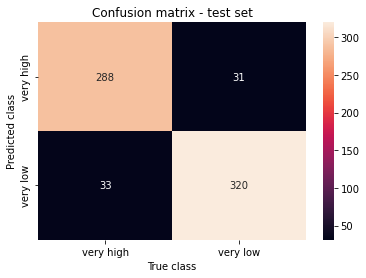

Accuracy: 0.90
Micro precision: 0.90
Micro recall: 0.90
Micro F1-score: 0.90
Macro precision: 0.90
Macro recall: 0.90
Macro F1-score: 0.90
Weighted precision: 0.90
Weighted recall: 0.90
Weighted F1-score: 0.90


In [57]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

# print(classification_report(y_test, y_pred, target_names=lb.classe_))

# ROC curve

## Training data (in-sample)

In [58]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_train_no = lb.fit_transform(y_train)
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

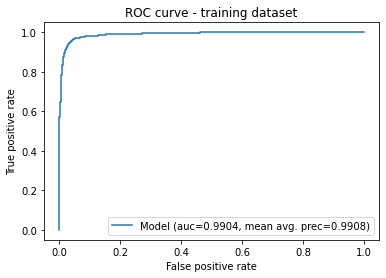

In [59]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test data (out-of-sample)

In [60]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

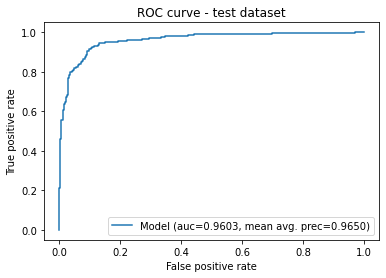

In [61]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

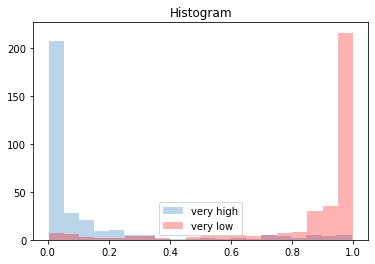

In [62]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(lb.classes_)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# Sample titles

In [63]:
combo = pd.concat([x_test, y_test], axis=1)
combo.reset_index(drop=True, inplace=True)
combo = pd.concat([combo, pd.Series(y_pred, name="pred")], axis=1)
combo.rename(columns={"clickbait": "truth"}, inplace=True)
combo.shape

(672, 3)

In [64]:
g = combo.groupby(["pred"], as_index=False).apply(lambda x: x.sample(5, random_state=682))
g[["title", "pred"]].head(10)
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)
g.head(10)

title        qtl       pred
0 345  Ted Cruz: Dems Suffer From ‘Trump Derangement ...  very high  very high
  483        Virus lottery: What could be next epidemic?  very high  very high
  442  16 Fucking Creepy Things That Actually Happene...  very high  very high
  89   These Are the Happiest and Healthiest Cities i...  very high  very high
  661                        10 Artists to Watch in 2017  very high  very high
1 276  Jimmy Butler Rips Marcus Smart for 'Acting Tou...   very low   very low
  116        Dutch election turns spotlight on Moroccans  very high   very low
  79   Pope Francis Urges Peace, Comforts Terror Vict...   very low   very low
  156  Hash browns are being recalled in 9 states bec...   very low   very low
  296  Trump's airstrike raises questions about congr...   very low   very low

# Save test set pred

In [65]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))

# Apply model on Youtube data

In [66]:
import pandas as pd
import os
import numpy as np

In [67]:
m_dir = r"../nlp models/roberta_2_classes"

x_alien = pd.read_pickle(os.path.join(m_dir, "x_train.pkl"))
y_alien = pd.read_pickle(os.path.join(m_dir, "y_train.pkl"))

In [68]:
x_alien_pp = preprocess_data(x_alien)
x_alien_tok = tokenize(x_alien_pp, tok)

y_alien_prob = model.predict(x_alien_tok[:2], steps=y_alien.shape[0])
y_pred = np.argmax(y_alien_prob, axis=1)

In [69]:
x_combo = pd.concat([x_alien.reset_index(), y_alien.reset_index(), pd.Series(y_pred, name="pred")], axis=1)

In [70]:
x_combo[["title", "qtl", "pred"]].iloc[412:418, :]

,title,qtl,pred
412,This is why we can't have nice things,very high,0
413,Spring Full Course - Learn Spring Framework In...,very low,0
414,Platinum (version 2) - Periodic Table of Videos,very high,1
415,When To Quit (According to Computer Science),very high,0
416,Have astronomers disproved the Big Bang?,very high,0
417,Outtakes #1: Crash Course Philosophy,very low,0


In [71]:
x_combo["y"] = (x_combo["qtl"] == "very high").astype("int32")
x_combo["y"].corr(x_combo["pred"])

-0.10979224833006108

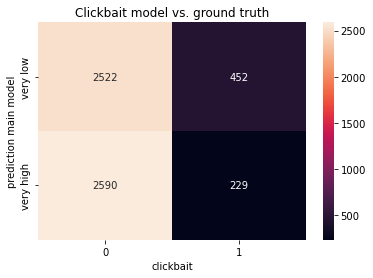

In [72]:
g = x_combo.groupby(["qtl", "pred"]).agg({"title": "count"}).reset_index()
g.rename(columns={"pred": "clickbait", "title": "count"}, inplace=True)
p = g.pivot(index="qtl", columns="clickbait", values="count")
sb.heatmap(p, annot=True, fmt="d")
plt.title("Clickbait model vs. ground truth")
plt.xlabel("clickbait")
plt.ylabel("prediction main model")
plt.savefig(os.path.join(p_dir, "confusion matrix clickbait vs ground truth.jpg"))
plt.show()

In [73]:
x_combo.loc[(x_combo["qtl"] == "very high") & (x_combo["pred"] == 1), "title"].head(10)

1       Gold, Sulfur, Vanadium and Cerium (feat. vsauce)
3                      Backspin Basketball Flies Off Dam
67     New Fundamental Particle Discovered?? + Challe...
113    StarTalk Live - Neil deGrasse Tyson and The Fu...
121    Stop Motion Mars Images from Indian Space Rese...
134    Will the Universe Expand Forever? | Space Time...
285        Feynman's Infinite Quantum Paths | Space Time
307    Explosive Bat in Slow Motion Ft. Stuff Made He...
310    Water Boiling at Everest - Periodic Table of V...
318    Should the First Mars Mission Be All Women? | ...
Name: title, dtype: object

Why is the correlation not higher?

* Video thumbnails and titles can be changed over the lifetime of a Youtube video
* This might be related to the sample being from science/educational video. The typical viewer seems to also be attracted by videos clearly stating their content (Derek Muller also mentions such as case -> lava lamp video). May be because he is looking for something specific or because she is interested in the topic anyway.

In [74]:
x_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5793 entries, 0 to 5792
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   index               5793 non-null   int64              
 1   id_video            5793 non-null   object             
 2   title               5793 non-null   object             
 3   channel_id          5793 non-null   object             
 4   channel_name        5793 non-null   object             
 5   published_video     5793 non-null   datetime64[ns, UTC]
 6   like_count          5793 non-null   float64            
 7   dislike_count       5793 non-null   float64            
 8   view_count_video    5793 non-null   float64            
 9   published_mth       5793 non-null   int64              
 10  title_len           5793 non-null   int64              
 11  id_channel          5793 non-null   object             
 12  view_count_channel  5793 non-null 

In [75]:
g = x_combo.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "y": "sum"}).reset_index()
g.rename(columns={"id_video": "video_count", "pred": "clickbait", "y": "very high"}, inplace=True)
g["vh_ratio"] = g["very high"] / g["video_count"]
g["cb_ratio"] = g["clickbait"] / g["video_count"]

In [76]:
lbl = ["very low", "low", "high", "very high"]
g["success class"] = pd.cut(g["vh_ratio"], 4, labels=lbl)

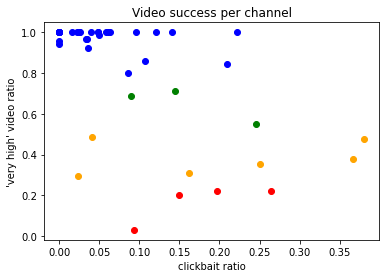

In [77]:
c = ["red", "orange", "green", "blue"]
i = 0
for l in lbl:
    plt.scatter(g.loc[g["success class"] == l, "cb_ratio"], g.loc[g["success class"] == l, "vh_ratio"], c=c[i])
    i += 1
plt.xlabel("clickbait ratio")
plt.ylabel("\'very high\' video ratio")
plt.title("Video success per channel")
plt.savefig(os.path.join(p_dir, "channel level corr clickbait vs video success.jpg"))
plt.show()

In [78]:
c = g["cb_ratio"].corr(g["vh_ratio"])
print("{:0.2f}".format(c))

-0.59


In [79]:
sp = g.loc[(g["cb_ratio"] < 0.3) & (g["vh_ratio"] > 0.8), :]
sp.sort_values(["vh_ratio", "cb_ratio"], ascending=False).head(10)

,channel_name,video_count,clickbait,very high,vh_ratio,cb_ratio,success class
17,PBS Space Time,117,26,117,1.0,0.222222,very high
40,Vsauce2,157,22,157,1.0,0.140127,very high
20,Physics Videos by Eugene Khutoryansky,33,4,33,1.0,0.121212,very high
29,Sixty Symbols,115,11,115,1.0,0.095652,very high
15,Numberphile,127,8,127,1.0,0.062992,very high
2,BrainCraft,33,2,33,1.0,0.060606,very high
25,Science ABC,17,1,17,1.0,0.058824,very high
5,D!NG,62,3,62,1.0,0.048387,very high
23,Real Engineering,62,3,62,1.0,0.048387,very high
0,3Blue1Brown,51,2,51,1.0,0.039216,very high


Removing the 2 channels with a clickbait ratio of 0 but at the same time being super successful

In [80]:
g.loc[(g["cb_ratio"] == 0), "channel_name"]

6     DoS - Domain of Science
8                Home Science
14          No Dumb Questions
16             OverSimplified
21                     Primer
27        ScienceClic English
36         The Science Asylum
37                Up and Atom
Name: channel_name, dtype: object

In [81]:
c = g.loc[(g["cb_ratio"] > 0), "cb_ratio"].corr(g.loc[(g["cb_ratio"] > 0), "vh_ratio"])
print("{:0.2f}".format(c))

-0.52


In [82]:
c2 = g.loc[~((g["cb_ratio"] < 0.3) & (g["vh_ratio"] > 0.8)), "cb_ratio"].corr(
    g.loc[~((g["cb_ratio"] < 0.3) & (g["vh_ratio"] > 0.8)), "vh_ratio"])
print("{:0.2f}".format(c2))

0.03
